Example notebook for base BIOSCREEN example

In [1]:
import sys

sys.path.insert(0, "/Users/jorrit/thesis/mibitrans")

About import statement

In [53]:
import matplotlib.pyplot as plt
import numpy as np
import mibitrans.analysis.mass_balance as mb
import mibitrans.data.check_input as chk
import mibitrans.data.read as rd
import mibitrans.transport.analytical_equation as eq
import mibitrans.visualize.plot_line as line
import mibitrans.visualize.plot_surface as surf
import mibitrans.visualize.show_mass_balance as smb


## Input

Below is example data from BIOSCREEN in the form of a dictionary, the same one sees when opening the Excel file for the first time. Note that since BIOSCREEN uses \[ft\] for many parameters, their value has been divided by 3.281 to convert to \[m\], the unit used in mibitrans.

#### By dictionary

In [4]:
parameter_dictionary = {
    # The groundwater flow velocity in [m/d]
    "flow_velocity": 113.8 / 3.281,
    # The dispersivity in the x (longitudinal) direction in [m]
    "dispersivity_x": 13.3 / 3.281,
    # The dispersivity in the y (transverse) direction in [m]
    "dispersivity_y": 1.3 / 3.281,
    # The dispersivity in the z (vertical) direction in [m]
    "dispersivity_z": 0,
    # Retardation factor for transported contaminant, no units
    "retardation_factor": 1,
    # Model extent in the x direction (length) in [m]
    "model_length": 320 / 3.281,
    # Model extent in the y direction (width) in [m]
    "model_width": 100 / 3.281,
    # Model end time in [years]
    "model_time": 6,
    # Thickness (z-direction, depth) of source zone in [m]
    "source_thickness": 10 / 3.281,
    # Concentration in the source zone as array with [y-location, concentration] in [[m], [g/m^3]]
    "source_concentration": np.array([[0, 13.68],
                                      [7 / 3.281, 2.508],
                                      [37 / 3.281, 0.057],
                                      [65 / 3.281, 0]]),
    # Mass of contaminant source in [kg], or "inf" for infinite source.
    "source_mass": 2000,
    # Effective soil porosity, no units
    "porosity": 0.3,
    # Contaminant half-life for 1st order decay
    "half_life": 0.15,
    # Difference between background oxygen and current oxygen concentration in groundwater, in [g/m^3]
    "delta_oxygen": 1.65,
    # Difference between background nitrate and current nitrate concentration in groundwater, in [g/m^3]
    "delta_nitrate": 0.7,
    # Current Fe2+ concentration in groundwater, in [g/m^3]
    "ferrous_iron": 16.6,
    # Difference between background sulfate and current sulfate concentration in groundwater, in [g/m^3]
    "delta_sulfate": 22.4,
    # Current methane concentration in groundwater, in [g/m^3]
    "methane": 6.6,
}

Clarification for source zone concentrations: Array starts with y = 0, the center of the plume and the corresponding concentration. It ends with the y-location of the end of the source zone, where concentration is equal to 0. As the plume is assumed to be symmetrical, the source zone is mirrored in the negative y-direction.

To make sure the parameter names are recognized, the module read takes the input data and gives an dictionary as output with standardized naming. And it reports any of the input parameters that were not recognized. The modules taking care of this can be found in 'mibitrans.data.read', already imported here as 'rd'. Which names/parameters are accepted can be found in 'mibitrans.data.parameter_information.key_dictionary'.

In [5]:
parameter_dictionary["dummy_key_to_show_read_functionality"] = 0
std_parameter_dictionary = rd.from_dict(dictionary=parameter_dictionary)
print(std_parameter_dictionary)

The following keys were not recognized and not included in output dictionary: ['dummy_key_to_show_read_functionality']
{'v': 34.68454739408717, 'alpha_x': 4.053642182261505, 'alpha_y': 0.3962206644315757, 'alpha_z': 0, 'R': 1, 'l_model': 97.5312404754648, 'w_model': 30.478512648582747, 't_model': 6, 'd_source': 3.047851264858275, 'c_source': array([[ 0.        , 13.68      ],
       [ 2.13349589,  2.508     ],
       [11.27704968,  0.057     ],
       [19.81103322,  0.        ]]), 'm_total': 2000, 'n': 0.3, 't_half': 0.15, 'dO': 1.65, 'dNO3': 0.7, 'Fe2': 16.6, 'dSO4': 22.4, 'CH4': 6.6}


#### Input checking

To run the model, certain parameters are required, differing per model and mode. From this point, all parameters should be formatted as the standardized dictionary generated by the read module.To manualy check if your input parameters are complete or which one you still need, and if your input parameters are of correct value and type, use mibitrans.data.check_input. The methods return True if its correct and False if it is not. Though the transport equation module already uses this to check if the input is valid, it might be useful to check this beforehand.

For the Domenico multidimensional transport model for decaying contaminant species, three model modes are recognized: "no_decay", "linear_decay" and "instant_reaction". Entering a name that is not recognized will have any module default to the no decay model.

In [14]:
# Make an object from the CheckInput class and set the desired mode to check on
check_obj = chk.CheckInput(std_parameter_dictionary, mode="no_decay")
# Check if all parameters are present
parameter_success = check_obj.check_parameter()

# Check if all parameters are of a correct type and value
value_success = check_obj.check_values()

print("")

# Purposely change porosity to a value outside of the range 0-1, which should not be accepted
std_parameter_dictionary["n"] = 2

check_obj_wrong = chk.CheckInput(std_parameter_dictionary, mode="no_decay")

# The parameter n is still present, so parameter check should be a success
parameter_success = check_obj_wrong.check_parameter()

# n is not between 0 and 1, so it mention n having an invalid value and be a failure
value_success = check_obj.check_values()

# Setting the n back to 0.3, otherwise there will be issues in the future!
std_parameter_dictionary["n"] = 0.3

All required parameters are present.
All parameters are of the correct type and value.

All required parameters are present.
Porosity should have a value between 0 and 1
The following parameters are of the wrong type: []
The following parameters have an invalid value: ['n']


## Analytical models

Now that we ensured that model parameters are valid, the dictionary can be passed on to the analytical equation. This is handled by the Transport class located in 'mibitrans.transport.analytical_equations'. The class sets up and calculates additional parameters, and makes the grid. The class object can then be used to perform any of the implemented models (which are class methods). In this case, the Dominco model is used.

Model resolution can be controlled by dx, dy and dt. If not given, it will automatically be calculated as a fraction of the model extent for that dimension.

The Transport class also runs the parameter checking functionality to make sure only valid values enter the model and raises an error is invalid values are encountered. 

In [39]:
# Dividing spatial resolution by 3.281 to get stepsizes that fit well into model extent
dx, dy, dt = 1 / 3.281, 1 / 3.281, 1
# Transport object for no decay model
eq_obj = eq.Transport(
    parameters=std_parameter_dictionary,
    mode="no_decay",
    # Dividing spatial resolution by 3.281 to get stepsizes that fit well into model extent
    dx=dx,
    dy=dy,
    dt=dt
)

# The object contains all initialized parameters, you can check these to see if they are as expected.
print("The source decay coefficient is:", eq_obj.k_source, "per year")
print("The time points are:", eq_obj.t)

# Concentration over time is returned as a 3D array, indexed as [time,y_position,x_position].
# x, y and t are all as 1D arrays.
cxyt, x, y, t = eq_obj.domenico()

# Linear decay model
eq_obj = eq.Transport(
    parameters=std_parameter_dictionary,
    mode="linear_decay",
    dx=dx,
    dy=dy,
    dt=dt
)
cxyt_lin, x, y, t = eq_obj.domenico()

# Instant reaction model
eq_obj = eq.Transport(
    parameters=std_parameter_dictionary,
    mode="instant_reaction",
    dx=dx,
    dy=dy,
    dt=dt
)
cxyt_inst, x, y, t = eq_obj.domenico()


The source decay coefficient is: 0.0016683053869019687 per year
The time points are: [1 2 3 4 5 6]


## Visualization

Now that the concentration distribution has been calculated, the contaminant plume can be visualized. This can be done as a 1D line plot over the plume center (found in mibitrans.visualize.plot_line), a 2D plot visualized as a flat surface (found in mibitrans.visualize.plot_surface) or a 2D plot visualized as a 3D surface (found in mibitrans.visualize.plot_surface). 

#### Plotting centerline

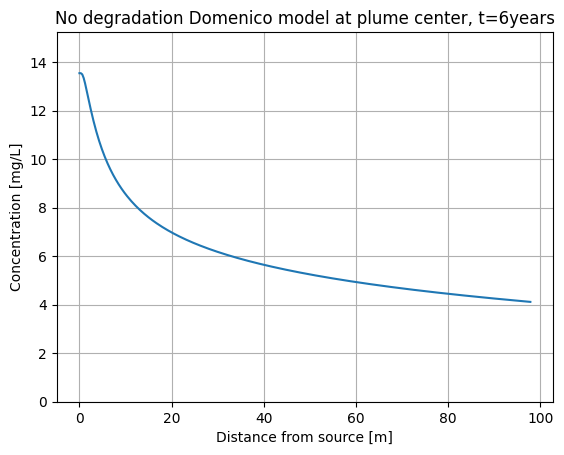

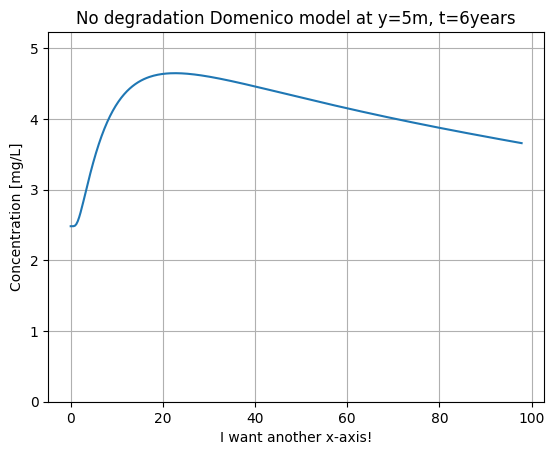

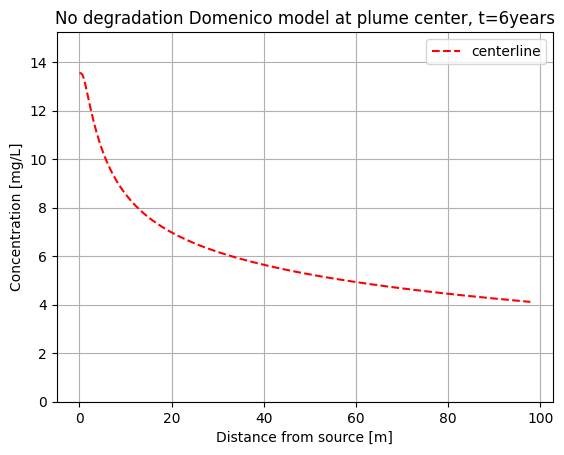

In [36]:
# Note that argument order is the same as the Transport module output, so one could do;
# plot = line.Lineplot(object.domenico())
plot = line.Lineplot(cxyt, x, y, t)
# Make a centerline plot at 6 years
plot.centerline(time=6)
plt.title("No degradation Domenico model at plume center, t=6years")
plt.show()

# If you want to plot somewhere else on the plume, you can use the optional y_pos argument. It will show the
# concentration profile across the plume at the y location closest to given y_pos.
plot.centerline(time=6, y_pos=5)
plt.title("No degradation Domenico model at y=5m, t=6years")
# If you want you can change the plot settings to the ones you prefer
plt.xlabel("I have changed!")
plt.show()

# Lastly, keyword arguments for plt.plot can be passed on through the function
plot.centerline(time=6, linestyle="--", color="red", label="centerline")
plt.title("No degradation Domenico model at plume center, t=6years")
plt.legend()
plt.show()

#### Plotting in 2D

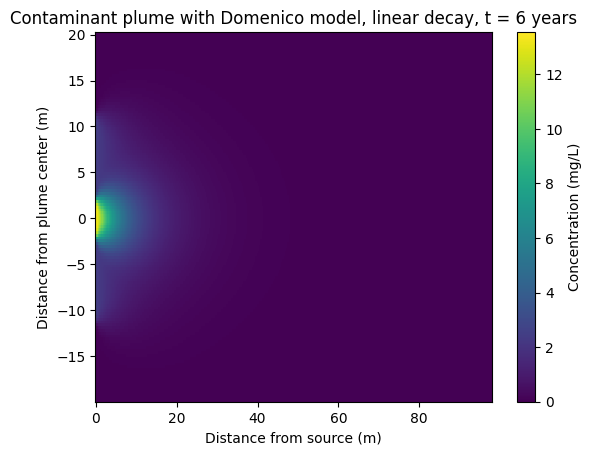

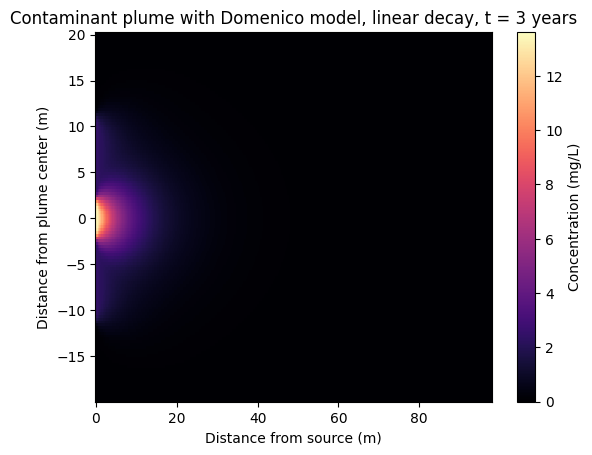

In [42]:
# Plot the x and y concentration distribution for linear decay model, uses plt.pcolormesh
plot = surf.Plume(cxyt_lin, x, y, t)
plot.flat(time=6)
plt.title("Contaminant plume with Domenico model, linear decay, t = 6 years")
plt.show()

# Function passes plt.colormesh keyword arguments
plot.flat(time=3, cmap="magma")
plt.title("Contaminant plume with Domenico model, linear decay, t = 3 years")
plt.show()

#### Plotting 2D in 3D

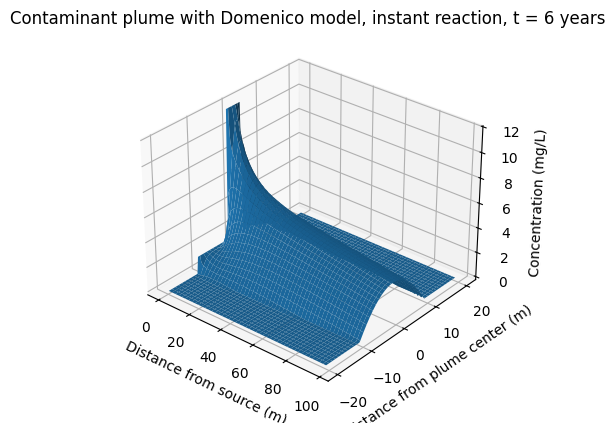

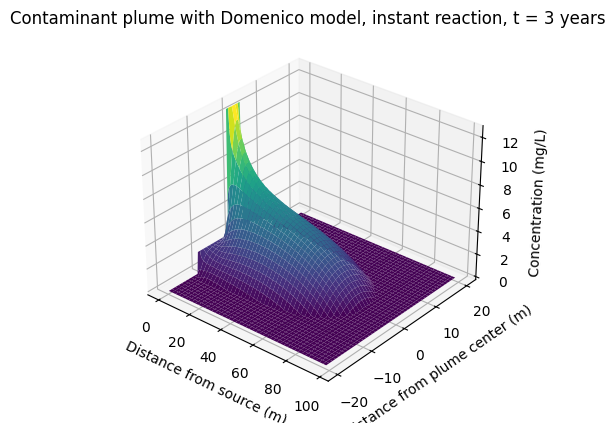

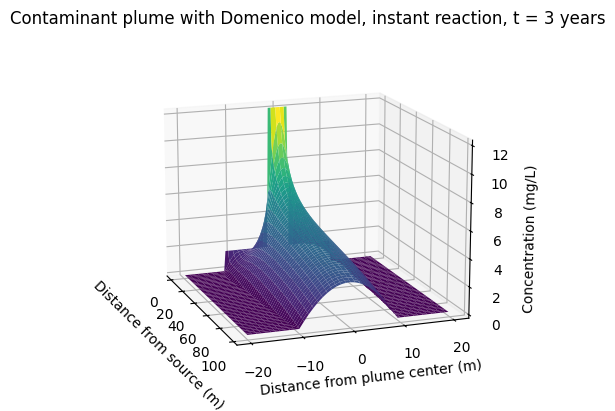

In [49]:
# Plot the x and y concentration distribution for instantaneous reaction model, uses plt.plot_surface
plot = surf.Plume(cxyt_inst, x, y, t)

plot.surface(time=6)
plt.title("Contaminant plume with Domenico model, instant reaction, t = 6 years")
plt.show()

# Function passes plt.plot_surface keyword arguments
plot.surface(time=3, cmap="viridis")
plt.title("Contaminant plume with Domenico model, instant reaction, t = 3 years")
plt.show()

# Function returns 'ax' object, use this to chnage view point of plot
ax = plot.surface(time=5, cmap="viridis")
ax.view_init(elev=15, azim=340)
plt.title("Contaminant plume with Domenico model, instant reaction, t = 3 years")
plt.show()

## Mass balance

To gain numerical information about mass transport in the model area, use the mass balance module in mibitrans.analysis.mass_balance. This returns a dictionary with mass values of each relevant model component (!!!varying!!! per model mode), in grams. Use the module mibitrans.visualization.show_mass_balance to show the mass balance in the form of a table.

In [63]:
# Set up mass balance object with given transport parameters
mb_obj = mb.MassBalance(std_parameter_dictionary, "linear_decay", dx, dy, dt)
# Get the mass balance at the given moment in time in the form of a dictionary
mb_dictionary = mb_obj.balance(time=6)
# The dictionary can be printed as is, but it is not convenient for visualization
print(mb_dictionary)
# Alternatively, it can visualized by the mass balance visualization module
smb.visualize_mass_balance(mb_dictionary)
# Furthermore, the dictionary can be accessed to do your own analysis or visualization.
print("The source mass after 6 years is:", mb_dictionary["source_mass_t"])

6
{'time': np.int64(6), 'source_mass_0': 2000000, 'source_mass_t': np.float64(1980080.1986176902), 'source_mass_change': np.float64(19919.801382309757), 'plume_mass_no_decay': np.float64(9174.727752065883), 'transport_outside_extent_nodecay': np.float64(10745.073630243875), 'plume_mass_linear_decay': np.float64(977.2405322740071), 'transport_outside_extent_lineardecay': np.float64(1144.5049659788008), 'plume_mass_degraded_linear': np.float64(17798.055884056947)}
MASS BALANCE FOR t = 6
+--------------+-----------+
| Source decay |  Mass (g) |
+--------------+-----------+
|  mass t = 0  |  2000000  |
|  mass t = 6  | 1980080.2 |
|  delta mass  |  19919.8  |
+--------------+-----------+
+---------------------------------------+----------+
|                No decay               | Mass (g) |
+---------------------------------------+----------+
|               plume mass              |  9174.7  |
| mass transported outside model extent | 10745.1  |
+---------------------------------------+-

In [64]:
# The function generate_mass_balance_tables generates the tables printed by visualize_mass_balance.
# You can accesss and change the tables themselves as a prettytable object by calling this function instead.
table_source, table_nodecay, table_lindecay, table_instant, table_electron = smb.generate_mass_balance_tables(
    mb_dictionary
)

table_source.add_row(["additional parameter", 1000])
print(table_source)

+----------------------+-----------+
|     Source decay     |  Mass (g) |
+----------------------+-----------+
|      mass t = 0      |  2000000  |
|      mass t = 6      | 1980080.2 |
|      delta mass      |  19919.8  |
| additional parameter |    1000   |
+----------------------+-----------+
